### Лабораторная работа №1
## Сбор, визуализация и анализ данных по графу


In [1]:
%%capture
!pip install feedparser transformers hf_xet plotly nbformat ipython ipywidgets ipykernel jupyterlab_widgets2

In [2]:
import feedparser
import urllib.request as libreq
import urllib.parse
import requests

1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 


In [3]:
topic = 'solar and stellar astrophysics'

2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций. 

In [4]:
params = {'search_query': f'all:"{topic}"', 'start': 0, 'max_results': 300}
r = requests.get('http://export.arxiv.org/api/query', params=params, timeout=30)
print(r)
docs = feedparser.parse(r.text)

titles = [d["title"] for d in docs["entries"]]
len(set(titles))

<Response [200]>


300

3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации). 

In [5]:
%%time
from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

CPU times: total: 7.16 s
Wall time: 16.9 s


In [6]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "abstract": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
          "tags": [tag['term'] for tag in entry['tags']]}
  pubs.append(data)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

df = pd.DataFrame(pubs)
df

,title,abstract,authors,tags
0,Multiplicity Study of Exoplanet Host Stars,We present recent results of our ongoing multi...,"[M. Mugrauer, R. Neuhäuser, C. Ginski, T. Eise...","[astro-ph.SR, astro-ph.EP]"
1,The Orbital Period of Three Cataclysmic Variab...,The publicly available WASP data are analysed ...,[Patrick Wils],[astro-ph.SR]
2,Asteroseismology observations and space missions,"Contribution to a book entitled ""Extraterrestr...","[T. Appourchaux, F. Grundahl]",[astro-ph.SR]
3,SS 433 in the cross hairs: two recent determin...,Two recent and robust determinations of the ma...,[M G Bowler],[astro-ph.SR]
4,Wolf 1465: Not a Bright Dwarf Carbon Star,Wolf 1465 has been suggested as a candidate fo...,"[Bruce Margon, Georgios Dimitriadis]",[astro-ph.SR]
...,...,...,...,...
295,Estimating stellar fundamental parameters usin...,This work addresses a procedure to estimate fu...,"[W. Farah, M. Gebran, F. Paletou, R. Blomme]",[astro-ph.SR]
296,Panchromatic imaging and spectroscopic observa...,We describe recent panchromatic imaging and sp...,"[Robert D. Gehrz, Nathan Smith, Dinesh Shenoy]",[astro-ph.SR]
297,Forbidden calcium lines as disc tracers,Forbidden emission lines are particularly valu...,"[Anna Aret, Michaela Kraus]",[astro-ph.SR]
298,Report on the O IV and S IV lines observed by ...,The O IV intercombination lines observed by th...,[Peter R. Young],[astro-ph.SR]


In [8]:
from itertools import combinations

def make_stop_set(phrase):
    words = phrase.lower().split()
    indices = list(range(len(words)))

    all_combinations = [
        ' '.join([words[i] for i in combo])
        for r in range(1, len(words)+1)
        for combo in combinations(range(len(words)), r)
    ]

    return set(all_combinations)

In [9]:
%%time

stop_set = make_stop_set(topic)

df["keywords"] = df.progress_apply(
    lambda row: list(
        filter(
            lambda kw: kw.lower() not in stop_set,
            pipe(" ".join([row["title"], row["abstract"]]))[0]["generated_text"].split(", ")
        )
    ),
    axis=1
)

  0%|          | 0/300 [00:00<?, ?it/s]

c:\Users\niken\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


CPU times: total: 53min 6s
Wall time: 14min


In [10]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df

,title,abstract,authors,tags,keywords
0,Multiplicity Study of Exoplanet Host Stars,We present recent results of our ongoing multi...,"M. Mugrauer, R. Neuhäuser, C. Ginski, T. Eisen...","astro-ph.SR, astro-ph.EP","Multiplicity Study, Exoplanet Host Stars"
1,The Orbital Period of Three Cataclysmic Variab...,The publicly available WASP data are analysed ...,Patrick Wils,astro-ph.SR,"WASP, Cataclysmic Variables, SDSS J171456"
2,Asteroseismology observations and space missions,"Contribution to a book entitled ""Extraterrestr...","T. Appourchaux, F. Grundahl",astro-ph.SR,"Asteroseismology, Space Missions, Extraterrest..."
3,SS 433 in the cross hairs: two recent determin...,Two recent and robust determinations of the ma...,M G Bowler,astro-ph.SR,"SS 433, Mass Ratio"
4,Wolf 1465: Not a Bright Dwarf Carbon Star,Wolf 1465 has been suggested as a candidate fo...,"Bruce Margon, Georgios Dimitriadis",astro-ph.SR,"Wolf 1465, Bright Dwarf Carbon Star"
...,...,...,...,...,...
295,Estimating stellar fundamental parameters usin...,This work addresses a procedure to estimate fu...,"W. Farah, M. Gebran, F. Paletou, R. Blomme",astro-ph.SR,"Stellar Parameters, PCA, GES, ESO Survey, Synt..."
296,Panchromatic imaging and spectroscopic observa...,We describe recent panchromatic imaging and sp...,"Robert D. Gehrz, Nathan Smith, Dinesh Shenoy",astro-ph.SR,"Panchromatic Imaging, Spectroscopic Observatio..."
297,Forbidden calcium lines as disc tracers,Forbidden emission lines are particularly valu...,"Anna Aret, Michaela Kraus",astro-ph.SR,"Forbidden Causal Lines, Disc Tracers, Spectros..."
298,Report on the O IV and S IV lines observed by ...,The O IV intercombination lines observed by th...,Peter R. Young,astro-ph.SR,"O IV, S IV, IRIS, Density Diagnostics"


In [ ]:
df.to_csv("./data/lab-1/dataset.csv", index=False)

4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотеки https://networkx.org/ (как альтернативный вариант можно посмотреть https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/)

In [12]:
import networkx as nx
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv("./data/lab-1/dataset.csv")
df.sample(5)

,title,abstract,authors,tags,keywords
75,Neutrino fluxes from CNO cycle in the Sun in t...,The computational analyses is presented of the...,"A. Kopylov, V. Petukhov",astro-ph.SR,"Neutrino Fluxes, CNO Cycle, Sun, Solar Model,"
293,Neutrino Quantum Kinetic Equations,Neutrinos propagate in astrophysical and cosmo...,Cristina Volpe,"astro-ph.SR, hep-ph, nucl-th","Neutrino, Quantum Kinetic Equations, Astrophys..."
249,V1117 Her: A Herbig Ae star at high Galactic l...,"We examine the long-term light curve, optical ...","M. Kun, M. Rácz, L. Szabados",astro-ph.SR,"V1117 Her, Herbig Ae, Galactic Location, Spect..."
24,Neutrino flavour conversion and supernovae,We summarize the recent developments in our un...,Cristina Volpe,"astro-ph.SR, hep-ph","Neutrino Flavour Conversion, Supernovae"
226,Electron Beam Evolution and Radio Emission in ...,This thesis considers the propagation of accel...,Heather Ratcliffe,astro-ph.SR,"Electron Beam Evolution, Radio Emission, Inhom..."


In [14]:
klist = [[word.strip() for word in keywords.split(",") if word] for keywords in df["keywords"].tolist()]
klist[:3]

[['Multiplicity Study', 'Exoplanet Host Stars'],
 ['WASP', 'Cataclysmic Variables', 'SDSS J171456'],
 ['Asteroseismology', 'Space Missions', 'Extraterrestrial Seismology']]

In [15]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist]))
edges = [tuple(sorted(edge)) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)]
weighted_edges[:10]

[('Astrophysical Environments', 'Neutrino Mixing', {'weight': 1}),
 ('Conference Scope', 'Program', {'weight': 1}),
 ('EUV Imaging Spectrometer', 'Hinode', {'weight': 1}),
 ('Pulsar Timing', 'Radio Pulsars', {'weight': 1}),
 ('Ap/Bp Stars', 'Pre-main-sequence', {'weight': 1}),
 ('Symbiotic Stars', 'Type Ia Supernovae', {'weight': 1}),
 ('Hydrodynamic Turbulence', 'Stars', {'weight': 1}),
 ('Explosions', 'Supernovae', {'weight': 1}),
 ('BH', 'Black Hole', {'weight': 1}),
 ('AGB', 'Mass Loss Imaging', {'weight': 1})]

In [16]:
len(set(edges)), len(weighted_edges)

(1226, 1226)

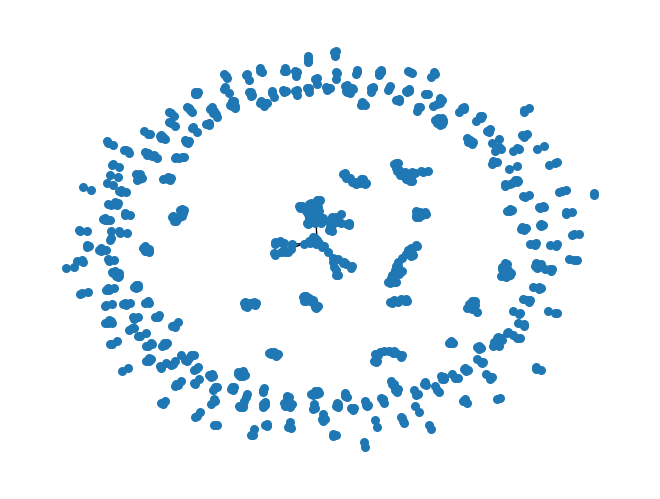

In [17]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.

In [18]:
communities = nx.community.louvain_communities(G)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 183, Modularity: 0.9828796570586189


Алгоритм Лувена дал качественный результат (модульность близка к 1). Почти каждое сообщество соответствует группе ключевых слов, которые часто встречаются вместе в публикациях, но почти не связаны с другими группами. Большое количество сообществ означает, что темы довольно узкие и сильно фрагментированы.

In [19]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities]
cdf = pd.DataFrame(comm_data)
cdf.describe()

,n_of_nodes
count,183.000000
mean,4.754098
std,4.973520
min,2.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,45.000000


Стандартное отклонение почти равно среднему - размеры сообществ сильно различаются. Большинство кластеров малы по размеру, однако имеется небольшое количество крупных кластеров. 

In [20]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
128,45,"{Mass discrepancy, Gauge-invari, Observational..."
144,39,"{Symbiotic Stars, V5485 Sagittarii, Linear, Se..."
65,26,"{Pairing Properties, Poloidal Magnetic Fields,..."


In [21]:
nodes = list(chain(*top3_comm["nodes"].tolist()))
S = G.subgraph(nodes)

In [22]:
def create_community_node_colors(graph, communities):
    colors = list(set(mcolors.TABLEAU_COLORS.values()))
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

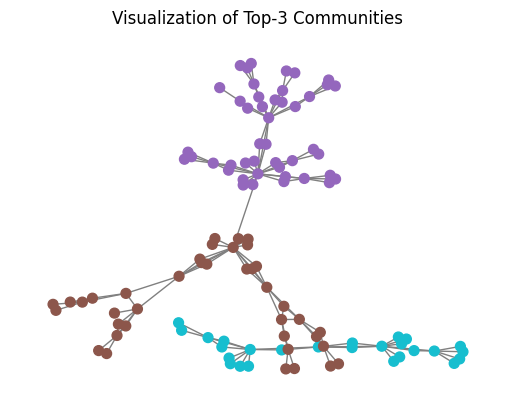

In [23]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    title = f"Visualization of Top-3 Communities"
    pos = nx.spring_layout(graph, iterations=100, seed=23)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=50,
        node_color=node_colors,
        edge_color="gray"
    )

visualize_communities(S, top3_comm["nodes"].tolist(), 1)    


In [24]:
import nbformat
import plotly.io as pio
pio.renderers.default = "notebook_connected"

communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# edges coordinates
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# degree labels
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# add nodes
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# background settings
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.

(Все значения центральностей библиотека networkx выводит в нормированном виде, поэтому получаются дробные значения.)

In [ ]:
top_amount = 10

from IPython.display import Image

Image(url="./data/lab-1/centralities.png")

#### Degree Centrality
количество узлов, с к которыми связан данный узел

In [26]:
top_degree = [
    (node[0], round(node[1],2))
    for node in sorted(nx.degree_centrality(S).items(), key=itemgetter(1), reverse=True)
][:top_amount]

top_degree

[('Magnetic Fields', 0.17),
 ('Stars', 0.13),
 ('Astronomy', 0.12),
 ('Neutron Star', 0.09),
 ('Neutron Stars', 0.08),
 ('Sun', 0.06),
 ('Binary Evolution', 0.06),
 ('Helicity', 0.06),
 ('Neutrino Fluxes', 0.06),
 ('Observations', 0.06)]

Эти слова имеют наибольшее количество прямых связей с другими ключевыми словами, они встречаются в большом числе публикаций одновременно с другими терминами. Например, Magnetic Fields — универсальное понятие, часто сопутствует самым разным исследованиям, поэтому оно соединяет множество других ключевых слов напрямую.

#### Betweenness centrality
количество кратчайших путей между каждой парой узлов, проходящих через данный узел

In [27]:
top_betweenness = [
    (node, round(score, 2))
    for node, score in sorted(nx.betweenness_centrality(S).items(), key=itemgetter(1), reverse=True)
][:top_amount]

top_betweenness

[('Magnetic Fields', 0.41),
 ('Stars', 0.37),
 ('Astronomy', 0.23),
 ('Binary Evolution', 0.15),
 ('Sun', 0.14),
 ('Observations', 0.08),
 ('Symbiotic Stars', 0.07),
 ('Neutrino Fluxes', 0.07),
 ('CNO Cycle', 0.05),
 ('Helicity', 0.04)]

Эти узлы лежат на путях между разными частями графа, то есть играют роль "мостов" между сообществами. Например, Magnetic Fields и Stars не только популярны, но и связывают разные тематические кластеры. Cюда попали более специализированные термины (Symbiotic Stars, CNO Cycle). Это значит, что именно они соединяют узкие области с более широкими темами.

#### Closeness centrality
обратная средняя длина кратчайшего пути от данного узла до всех других достижимых узлов

In [28]:
top_closeness = [
    (node, round(score, 2))
    for node, score in sorted(nx.closeness_centrality(S).items(), key=itemgetter(1), reverse=True)
][:top_amount]

top_closeness

[('Magnetic Fields', 0.3),
 ('Stars', 0.29),
 ('Astronomy', 0.25),
 ('Binary Evolution', 0.23),
 ('Zeeman Effect', 0.23),
 ('FORS2', 0.23),
 ('Sun', 0.23),
 ('Astrophysical Studies', 0.22),
 ('Star clusters', 0.22),
 ('Galaxies', 0.22)]

Эти узлы имеют наименьшую среднюю дистанцию до всех остальных, то есть быстрее всего можно достичь других терминов, начиная от них. Magnetic Fields снова на первом месте: от этого узла легко дойти до любого другого ключевого слова. Попали и более узкие термины (Zeeman Effect, FORS2).

#### Вывод

Magnetic Fields, Stars, Astronomy лидируют во всех трёх метриках - это фундаментальные термины, которые широко встречаются, соединяют разные области и структурно расположены в центре графа.

7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь (выше вес ребра). Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.

In [29]:
nodes = list(zip(df["title"], klist))
edges = list(combinations(nodes, 2))
edges = [(edge[0][0], edge[1][0], len(set(edge[0][1]) & set(edge[1][1]))) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edge[2]}) for edge in set(edges) if edge[2] != 0]
sorted(weighted_edges, key=lambda x: x[2]['weight'], reverse=True)[:10]

[('Results of UBV Photoelectric Observations of the Early-Type Eclipsing\n  Binary System XZ Cep',
  'Results of UBV Photoelectric Observations of eclipsing binary RY Sct',
  {'weight': 2}),
 ('Are disk in dwarf novae during their superoutbursts really eccentric?',
  'Direct Evidence for Modulated Irradiation of Secondary Components in\n  Dwarf Novae during Superoutbursts',
  {'weight': 2}),
 ('The search for progenitor models of type Ia supernovae',
  'Symbiotic stars as possible progenitors of SNe Ia: binary parameters and\n  overall outlook',
  {'weight': 2}),
 ('Radiative transfer in stellar atmospheres',
  'Current status of NLTE analysis of stellar atmospheres',
  {'weight': 2}),
 ('Radiative transfer in stellar atmospheres',
  'Solution of NLTE Radiative Transfer Problems Using Forth-and-Back\n  Implicit Lambda Iteration',
  {'weight': 2}),
 ('Studying the hybrid pulsator 12 Lacertae: mode identification and\n  complex seismic modelling',
  'An attempt of seismic modelling of Be

In [30]:
len(set(edges)), len(weighted_edges)

(44850, 184)

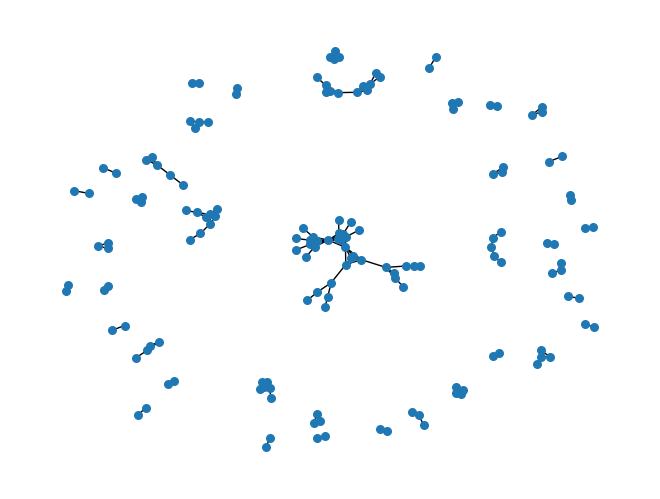

In [31]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

In [40]:
def find_closest(graph, pub_title, top_k):
    if pub_title not in graph:
        return []

    lengths = nx.single_source_dijkstra_path_length(graph, pub_title, weight=lambda u, v, d: 1/d["weight"])
    return sorted(lengths.items(), key=lambda x: x[1])[1:min(top_k, len(lengths))]

In [54]:
import random 

title = random.choice(df["title"]) # "Radiative transfer in stellar atmospheres"

print(title)
find_closest(G, title, 5)

Basics of the NLTE physics


[('Radiative transfer in stellar atmospheres', 1.0),
 ('Statistical equilibrium equations for trace elements in stellar\n  atmospheres',
  1.0),
 ('Current status of NLTE analysis of stellar atmospheres', 1.0),
 ('Solution of NLTE Radiative Transfer Problems Using Forth-and-Back\n  Implicit Lambda Iteration',
  1.5)]